# Red and White Wine
## Dataset description

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: [http://www.vinhoverde.pt/en/](http://www.vinhoverde.pt/en/)  or the reference [Cortez et al., 2004].
Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are munch more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 42(4):547-553. ISSN: 0167-9236.


What might be an interesting thing to do, is aside from using regression modelling, is to set an arbitrary cutoff for your dependent variable (wine quality) at e.g. 7 or higher getting classified as 'good/1' and the remainder as 'not good/0'.
This allows you to practice with hyper parameter tuning on e.g. decision tree algorithms looking at the ROC curve and the AUC value.
Without doing any kind of feature engineering or overfitting you should be able to get an AUC of .88 (without even using random forest algorithm)

KNIME is a great tool (GUI) that can be used for this.

1 - File Reader (for csv) to linear correlation node and to interactive histogram for basic EDA.

2- File Reader to 'Rule Engine Node' to turn the 10 point scale to dichtome variable (good wine and rest), the code to put in the rule engine is something like this:

$quality$ > 6.5 => "good"
TRUE => "bad"

3- Rule Engine Node output to input of Column Filter node to filter out your original 10point feature (this prevent leaking)

4- Column Filter Node output to input of Partitioning Node (your standard train/tes split, e.g. 75%/25%, choose 'random' or 'stratified')

5- Partitioning Node train data split output to input of Train data split to input Decision Tree Learner node and

6- Partitioning Node test data split output to input Decision Tree predictor Node

7- Decision Tree learner Node output to input Decision Tree Node input

8- Decision Tree output to input ROC Node.. (here you can evaluate your model base on AUC value)

In [1]:
#Importing required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
#Loading dataset
df_red_wine = pd.read_csv('winequality-red.csv')
df_white_wine = pd.read_csv('winequality-white.csv', sep=';')
red_wine = df_red_wine.copy()
white_wine = df_white_wine.copy()

In [3]:
# Рассмотрим пример загруженных данных
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# Получим информацию о датасете
red_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
# Получим описание значений каждого признака
red_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Аналогично рассмотрим датасет с белым вином.

In [6]:
white_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [7]:
white_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [8]:
white_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


В датасетах отсутствуют пропущенные данные. Все характеристики вин заданы числами формата float, только оценка вина представлена в формате целых чисел.

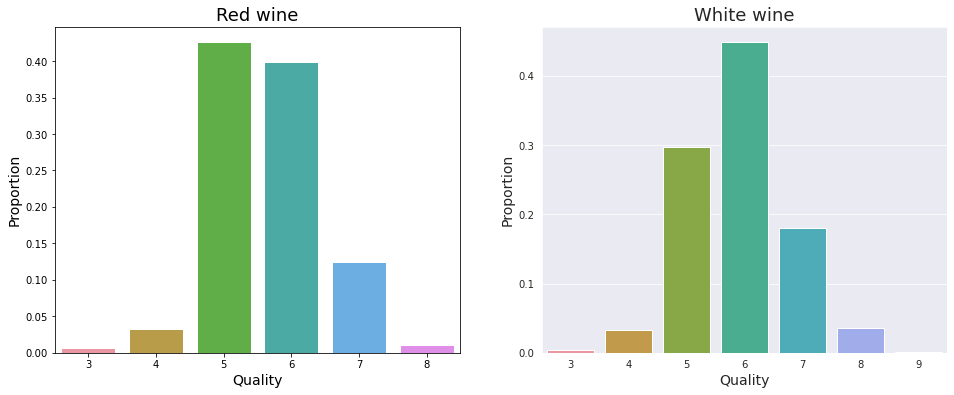

In [9]:
# Построим распределение оценок для красного и белого вина
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.set_style("darkgrid")
sns.set_palette('tab10', n_colors=3)
sns.barplot(x = red_wine.quality.value_counts().index, y = red_wine.quality.value_counts()/ red_wine.shape[0])
plt.title('Red wine', fontsize = 18)
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Proportion', fontsize=14);


plt.subplot(122)
sns.set_style("darkgrid")
sns.barplot(x = white_wine.quality.value_counts().index, y = white_wine.quality.value_counts()/ white_wine.shape[0])
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('White wine', fontsize = 18);

Распределение оценок сильно отличается, наибольшая доля состоит из оценок 5,6 и 7. При этом отличается распределение и для разных видов вин.
В связи с этим объединим датасеты с красным и белым вином в один с указанием вида вина.

In [10]:
#  Объеденим датасеты с красным и белым вином, предварительно добавив признак Type(red, white)
red_wine['Type'] = 'red'
white_wine['Type'] = 'white'
wine = pd.concat([red_wine, white_wine], axis=0)
# Проверим равенство количества строк
red_wine.shape[0] + white_wine.shape[0] == wine.shape[0]

True

In [11]:
# Рассмотрим корреляцию признаков между собой, а также влияние признаков на оценку вина.
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)

    _ = sns.heatmap(
        df.corr(),
        cmap = colormap,
        square=True,
        cbar_kws={'shrink':.9 },
        ax=ax,
        annot=True,
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )

    plt.title('Pearson Correlation of Features', y=1.05, size=15)

Можно удалить признак total sulfur dioxide, так как он коррелирует с признаком free sulfur dioxide.

#### Предобработка данных
Заменим оценки вина, приведенные в числовом дискретным виде, на бинарную классифкацию, где 1 - оценка вина выше 6.5 ('good'), 0 - оценка вина меньше 6.5 ('bad'), как предложено в задании.


In [12]:
wine.quality = wine.quality.apply(lambda x: 1 if x >= 6.5 else 0)

Аналогично преобразуем признак Type в бинарную классификацию для учета этого признака при обучении модели ( 1 - 'red wine', 0 - 'white wine').

In [13]:
wine.Type = wine.Type.apply(lambda x: 1 if x == 'red' else 0)

In [14]:
wine[['quality', 'Type']].head()

,quality,Type
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


##### Рассмотрим соотношения хорошего и плохого вина в разрезе типа винa

<AxesSubplot:xlabel='Type', ylabel='count'>

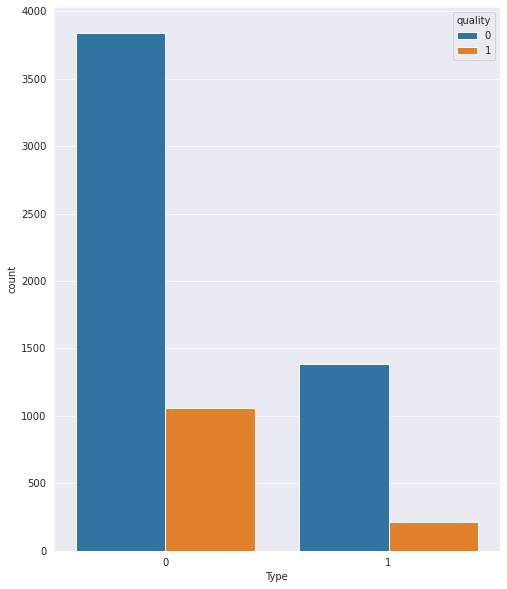

In [15]:
plt.figure(figsize=(8,10))
sns.countplot(data=wine, x = 'Type', hue='quality')

Для красного вина имеем соотношение количества хорошего вина к плохому как 1 : 6,3
Для белого вина имеем соотношение количества хорошего вина к плохому как 1 : 3,6
При этом количество представленных белых вин превосходит число красного вина, поэтому учтем этот факт при разделении датасета на обучающую и тестовую выборки.

In [16]:
X = wine.drop('quality', axis = 1)
y = wine.quality

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=wine[['Type', 'quality']])
print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_train по классам: [4175 1022]
Количество строк в y_test по классам: [1045  255]


# Построение модели

Определим наш baseline для дальнейшего улучшения модели. Для этого используем LogisticRegression.

In [18]:
# Инициализируем модель и обучим на тренировочной выборке
clf = LogisticRegression(solver='liblinear', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Будем записывать метрики каждой модели для дальнейшего сравнения
data_score = pd.DataFrame([[accuracy_score(y_test,y_pred), precision_score(y_test,y_pred), recall_score(y_test,y_pred), f1_score(y_test,y_pred)]], columns=['accuracy', 'precision', 'recall', 'f1'], index=['LogisticRegression'])
data_score

,accuracy,precision,recall,f1
LogisticRegression,0.820769,0.612245,0.235294,0.339943


Определим гиперпараметры для повышения точности логистической регрессии с помощью GridSearchCV

In [19]:
#Определим лучший набор параметров для логистической регрессии
clf = LogisticRegression(random_state=42)
parameters = [
    {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
     'C': np.logspace(0, 5, 10),
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'max_iter': [50, 100, 150, 200]
    }
]
grid = GridSearchCV(clf, param_grid=parameters, n_jobs=-1);
best_clf = grid.fit(X_train, y_train)
best_clf.best_estimator_

/home/alex-ned/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex-ned/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex-ned/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex-ned/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex-ned/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex-ned/anaconda3/lib/python3.9/site-packages/sklearn

LogisticRegression(C=3.5938136638046276, max_iter=50, random_state=42,
                   solver='newton-cg')

In [20]:
clf = LogisticRegression(C=3.5938136638046276, class_weight=None, dual=False,
                         fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                         max_iter=50, multi_class='auto', n_jobs=None, penalty='l2',
                         random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                         warm_start=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
temp_df = pd.DataFrame([[accuracy_score(y_test,y_pred), precision_score(y_test,y_pred), recall_score(y_test,y_pred), f1_score(y_test,y_pred)]], columns=['accuracy', 'precision', 'recall', 'f1'], index=['LogisticRegression + GridSearch'])
data_score = data_score.append(temp_df)
data_score

/home/alex-ned/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


,accuracy,precision,recall,f1
LogisticRegression,0.820769,0.612245,0.235294,0.339943
LogisticRegression + GridSearch,0.819231,0.584746,0.270588,0.369973


Используем для обучения модели RandomForestClassifier

In [21]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
temp_df = pd.DataFrame([[accuracy_score(y_test,y_pred), precision_score(y_test,y_pred), recall_score(y_test,y_pred), f1_score(y_test,y_pred)]], columns=['accuracy', 'precision', 'recall', 'f1'], index=['RandomForest'])
data_score = data_score.append(temp_df)

In [22]:
data_score

,accuracy,precision,recall,f1
LogisticRegression,0.820769,0.612245,0.235294,0.339943
LogisticRegression + GridSearch,0.819231,0.584746,0.270588,0.369973
RandomForest,0.896154,0.833333,0.588235,0.689655


Видно, что все метрики улучшились при использовании RandomForestClassifier. Аналогично попытаемся улучшить модель при изменении гиперпараметров. Будем использовать RandomizedSearchCV для ускорения процесса выбора гиперпараметров.

In [23]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [24]:
clf = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [25]:
random_search.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

Обучим модель с использованием лучшего набора параметров

In [26]:
clf = RandomForestClassifier(n_estimators=1400, min_samples_split=2,min_samples_leaf=1,max_features= 'auto', max_depth= 100, bootstrap=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
temp_df = pd.DataFrame([[accuracy_score(y_test,y_pred), precision_score(y_test,y_pred), recall_score(y_test,y_pred), f1_score(y_test,y_pred)]], columns=['accuracy', 'precision', 'recall', 'f1'], index=['RandomForest+RandomSearch'])
data_score = data_score.append(temp_df)
data_score

,accuracy,precision,recall,f1
LogisticRegression,0.820769,0.612245,0.235294,0.339943
LogisticRegression + GridSearch,0.819231,0.584746,0.270588,0.369973
RandomForest,0.896154,0.833333,0.588235,0.689655
RandomForest+RandomSearch,0.896923,0.834254,0.592157,0.692661


Можно увидеть, что все опять метрики улучшились при использовании RandomForestClassifier с учетом применения гиперпараметров, полученных с помощью RandomizedSearchCV.

Добавим в сравнение качества применяемых моделей  алгоритмы AdaBoostClassifier и XGBClassifier.

XGBClassifier

In [27]:
clf = xgboost.XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
temp_df = pd.DataFrame([[accuracy_score(y_test,y_pred), precision_score(y_test,y_pred), recall_score(y_test,y_pred), f1_score(y_test,y_pred)]], columns=['accuracy', 'precision', 'recall', 'f1'], index=['XGBClassifier'])
data_score = data_score.append(temp_df)
data_score

/home/alex-ned/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:51:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,accuracy,precision,recall,f1
LogisticRegression,0.820769,0.612245,0.235294,0.339943
LogisticRegression + GridSearch,0.819231,0.584746,0.270588,0.369973
RandomForest,0.896154,0.833333,0.588235,0.689655
RandomForest+RandomSearch,0.896923,0.834254,0.592157,0.692661
XGBClassifier,0.880000,0.732394,0.611765,0.666667


In [28]:
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
temp_df = pd.DataFrame([[accuracy_score(y_test,y_pred), precision_score(y_test,y_pred), recall_score(y_test,y_pred), f1_score(y_test,y_pred)]], columns=['accuracy', 'precision', 'recall', 'f1'], index=['AdaBoostClassifier'])
data_score = data_score.append(temp_df)
data_score

,accuracy,precision,recall,f1
LogisticRegression,0.820769,0.612245,0.235294,0.339943
LogisticRegression + GridSearch,0.819231,0.584746,0.270588,0.369973
RandomForest,0.896154,0.833333,0.588235,0.689655
RandomForest+RandomSearch,0.896923,0.834254,0.592157,0.692661
XGBClassifier,0.880000,0.732394,0.611765,0.666667
AdaBoostClassifier,0.820000,0.569536,0.337255,0.423645


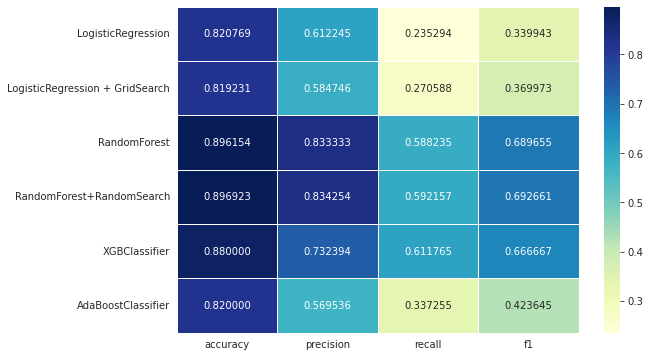

In [30]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_score, annot=True, fmt="f", linewidths=.8, ax=ax, cmap="YlGnBu");